In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

from keras.models import load_model



import utils
from sklearn import utils
from public_test import *
from testutils import *

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)



In [31]:
IMAGE_DIR = "archive/images"


labels = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']




In [32]:
train_df = pd.read_csv("archive/train_data.csv")
test_df = pd.read_csv("archive/test_data.csv")
valid_df = pd.read_csv("archive/val_data.csv")

In [33]:

def detect_patient_overlap(dataframe1, dataframe2, patient_column):

    # Extracting patient IDs from both dataframes
    patients_df1 = set(dataframe1[patient_column].unique())
    patients_df2 = set(dataframe2[patient_column].unique())
    
    # Finding the intersection of patient IDs between the two sets
    common_patients = patients_df1 & patients_df2
    
    # Checking if there are any common patients
    has_overlap = len(common_patients) > 0
    
    return has_overlap

In [34]:
print("Overlap detected between training and validation sets: {}".format(detect_patient_overlap(train_df, valid_df, 'PatientId')))
print("Overlap detected between training and test sets: {}".format(detect_patient_overlap(train_df, test_df, 'PatientId')))
print("Overlap detected between validation and test sets: {}".format(detect_patient_overlap(valid_df, test_df, 'PatientId')))


Overlap detected between training and validation sets: False
Overlap detected between training and test sets: False
Overlap detected between validation and test sets: False


In [35]:
def get_train_generator(dataframe, images_folder, feature_column, labels_columns, mix=True, size_per_batch=32, random_seed=1, width=320, height=320):

    print("Preparing training data loader...") 
    # Standardize images
    img_data_preprocessor = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
    
    
    # Generate data batch with defined size and image dimensions
    data_loader = img_data_preprocessor.flow_from_dataframe(
            dataframe=dataframe,
            directory=images_folder,
            x_col=feature_column,
            y_col=labels_columns,
            class_mode="raw",
            batch_size=size_per_batch,
            shuffle=mix,
            seed=random_seed,
            target_size=(width,height))
    
    return data_loader

In [36]:
def get_test_and_valid_generator(validation_data, test_data, training_data, images_path, feature_column, target_columns, sampling_size=100, size_per_batch=32, random_seed=1, img_width=320, img_height=320):

    print("Preparing validation and test data loaders...")
    # Create a raw data generator for sampling
    initial_data_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=training_data,
        directory=images_path,
        x_col="Image",
        y_col=target_columns,
        class_mode="raw",
        batch_size=sampling_size,
        shuffle=True,
        target_size=(img_width, img_height))
    
    # Extract a data sample for normalization purposes
    data_batch = initial_data_generator.next()
    sample_data = data_batch[0]

    # Configure generator for standardized image inputs
    standardized_image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True)
    
    # Standardize based on the training data sample
    standardized_image_generator.fit(sample_data)

    # Setup validation data loader
    validation_loader = standardized_image_generator.flow_from_dataframe(
            dataframe=validation_data,
            directory=images_path,
            x_col=feature_column,
            y_col=target_columns,
            class_mode="raw",
            batch_size=size_per_batch,
            shuffle=False,
            seed=random_seed,
            target_size=(img_width,img_height))

    # Setup test data loader
    test_loader = standardized_image_generator.flow_from_dataframe(
            dataframe=test_data,
            directory=images_path,
            x_col=feature_column,
            y_col=target_columns,
            class_mode="raw",
            batch_size=size_per_batch,
            shuffle=False,
            seed=random_seed,
            target_size=(img_width,img_height))
    
    return validation_loader, test_loader

In [37]:
train_generator = get_train_generator(train_df, IMAGE_DIR, "Image", labels)

Preparing training data loader...
Found 77871 validated image filenames.


In [38]:
valid_generator, test_generator= get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "Image", labels)

Preparing validation and test data loaders...
Found 77871 validated image filenames.
Found 8653 validated image filenames.
Found 25596 validated image filenames.


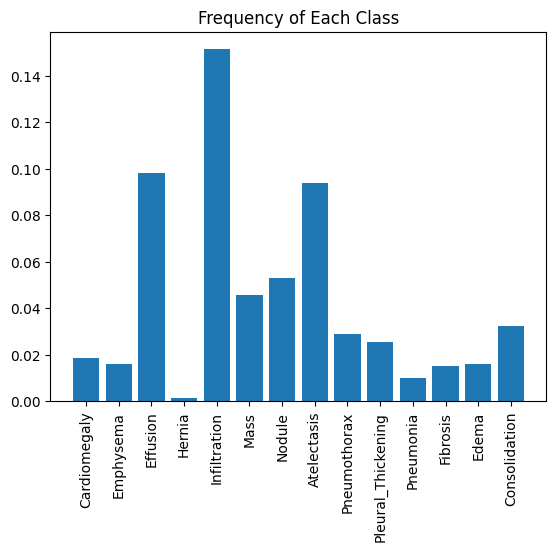

In [39]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_generator.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

In [40]:
def compute_class_freqs(label_array):
    # Determine the total number of entries
    total_entries = label_array.shape[0]
    
    # Calculate frequencies of the positive labels
    freq_of_positives = np.sum(label_array, axis=0) / total_entries
    # Derive frequencies of the negative labels
    freq_of_negatives = 1 - freq_of_positives

    return freq_of_positives, freq_of_negatives

In [41]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)

<Axes: xlabel='Class', ylabel='Value'>

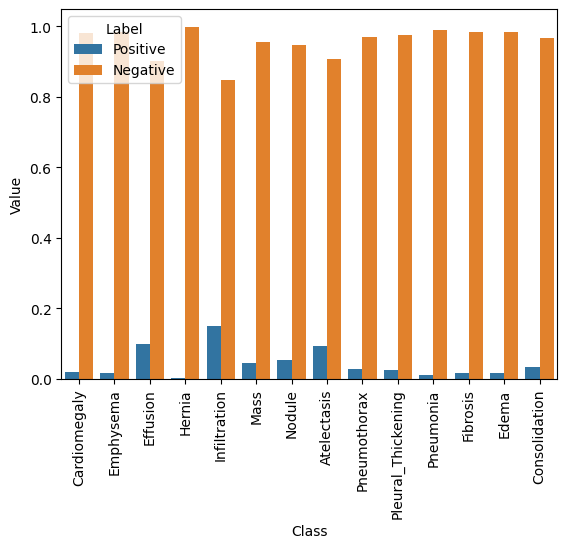

In [42]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})

# New DataFrame for negative labels, with red color
new_data = pd.DataFrame({"Class": labels, "Label": "Negative", "Value": freq_neg, "Color": "red"})

# Concatenating the original and new data
data = pd.concat([data, new_data], ignore_index=True)

# Plotting
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label", data=data)

In [43]:
pos_weights = freq_neg
neg_weights = freq_pos

pos_contribution = freq_pos * pos_weights
neg_contribution = freq_neg * neg_weights

pos_contribution, neg_contribution

(array([0.0184963 , 0.01581937, 0.0883923 , 0.00156424, 0.12841832,
        0.04373162, 0.05026948, 0.08520702, 0.02832519, 0.02469482,
        0.00979037, 0.0149859 , 0.01563291, 0.031362  ]),
 array([0.0184963 , 0.01581937, 0.0883923 , 0.00156424, 0.12841832,
        0.04373162, 0.05026948, 0.08520702, 0.02832519, 0.02469482,
        0.00979037, 0.0149859 , 0.01563291, 0.031362  ]))

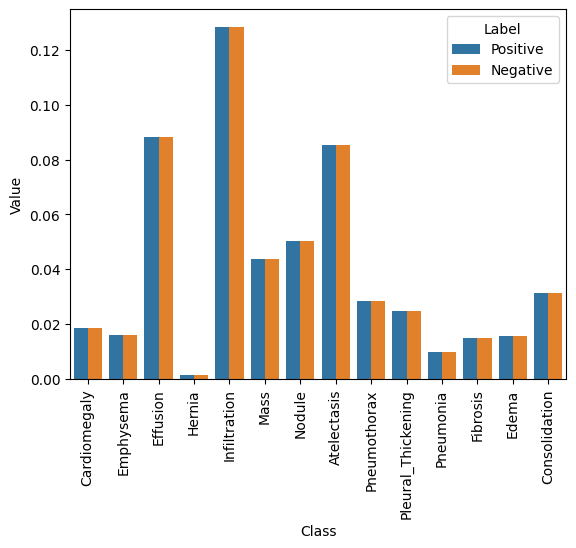

In [44]:
# Creating DataFrame for positive contributions
data_pos = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})

# Creating DataFrame for negative contributions
data_neg = pd.DataFrame({"Class": labels, "Label": "Negative", "Value": neg_contribution})

# Concatenating the positive and negative data
data = pd.concat([data_pos, data_neg], ignore_index=True)

# Plotting
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label", data=data)
plt.show()

In [45]:

def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):

    def weighted_loss(y_true, y_pred):
        print("y_true shape:", K.shape(y_true))  # Debug print
        print("y_pred shape:", K.shape(y_pred))  # Debug print
        

        # initialize loss to zero
        loss = 0.0
        
        ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            loss_pos = -1. * K.mean(K.cast(pos_weights[i], 'float32') * K.cast(y_true[:, i], 'float32') * K.log(K.cast(y_pred[:, i], 'float32') + epsilon))
            
            loss_neg = -1 * K.mean(K.cast(neg_weights[i], "float32") * (1 - K.cast(y_true[:, i], 'float32')) * K.log(1 - K.cast(y_pred[:, i], 'float32') + epsilon))

            
            loss += loss_pos + loss_neg
        return loss
        
        
    
        ### END CODE HERE ###
    return weighted_loss


In [46]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau, EarlyStopping
import datetime

# create the base pre-trained model
base_model = DenseNet121(weights='models/densenet.hdf5', include_top=False)

x = base_model.output
# x = tf.cast(x, tf.float32)
# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights))

# Callbacks
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, mode='min', min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

y_true shape: Tensor("loss/dense_loss/Shape:0", shape=(2,), dtype=int32)
y_pred shape: Tensor("loss/dense_loss/Shape_1:0", shape=(2,), dtype=int32)


In [ ]:
history = model.fit(train_generator, 
                              validation_data=valid_generator,
                              steps_per_epoch=100, 
                              validation_steps=25, 
                              epochs = 20, callbacks=[checkpoint, tensorboard, reduce_lr, early_stopping])

plt.plot(history.history['loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
model.save("trained_model_2.h5")
plt.show()

In [ ]:
# print loss value
plt.plot(history.history['val_loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Value Loss Curve")

plt.show()

In [47]:
model.load_weights("trained_model_2.h5")

In [ ]:
predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))

print(predicted_vals[0])

In [50]:
pos_weights, neg_weights
# get_weighted_loss(pos_weights, neg_weights)

(array([0.98114831, 0.98392213, 0.9020046 , 0.99843331, 0.84868565,
        0.95416779, 0.9469122 , 0.90594701, 0.97082354, 0.97466323,
        0.99011185, 0.98478252, 0.98411475, 0.96758742]),
 array([0.01885169, 0.01607787, 0.0979954 , 0.00156669, 0.15131435,
        0.04583221, 0.0530878 , 0.09405299, 0.02917646, 0.02533677,
        0.00988815, 0.01521748, 0.01588525, 0.03241258]))

In [48]:
model = load_model('trained_model_2.h5', custom_objects={'weighted_loss': get_weighted_loss(pos_weights, neg_weights)})

y_true shape: Tensor("loss_1/dense_19_loss/Shape:0", shape=(2,), dtype=int32)
y_pred shape: Tensor("loss_1/dense_19_loss/Shape_1:0", shape=(2,), dtype=int32)


In [49]:
# code to predict a single file
K.clear_session()
from keras.utils import load_img, img_to_array
from keras.models import load_model
import numpy as np
import tensorflow as tf



# Function to prepare the image
def prepare_image(image_path, target_size):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return img_array_expanded_dims / 255.

# Replace 'path/to/your/image' with the path to the image you want to predict on
img_path = 'archive/images/00018494_008.png'
# pick a random image from the test data

prepared_img = prepare_image(img_path, target_size=(320, 320))
# K.clear_session()

predictions = model.predict(prepared_img)

print(predictions)

# Assuming your model predicts probabilities for each class
# and you have a list of class labels
labels = ['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax', 'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation']


# Print predictions for each label
for label, prediction in zip(labels, predictions[0]):
    print(f"{label}: {prediction*100:.2f}%")

/Users/hammad/Chestxray/final-year-project-HammadsGit/.venv/lib/python3.10/site-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


ValueError: Tensor Tensor("dense_19/Sigmoid:0", shape=(None, 14), dtype=float32) is not an element of this graph.

In [ ]:
# creating file for the predictions

filenames = test_generator.filenames
true_labels = test_generator.labels
predicted_vals = predicted_vals  # This assumes 'predicted_vals' is already defined and contains predictions from your model

# Convert true labels to a DataFrame
df_labels = pd.DataFrame(true_labels, columns=labels)

# Add the image filenames to the DataFrame
df_labels['Image'] = filenames


df_labels['Hello'] = 1

# Convert predicted probabilities to a DataFrame
df_predictions = pd.DataFrame(predicted_vals, columns=[f"{label}_pred" for label in labels])

# Concatenate the true labels and predicted probabilities DataFrames
df_combined = pd.concat([df_labels, df_predictions], axis=1)

# Ensure the filenames are the first column
df_combined = df_combined[['Image'] + [col for col in df_combined.columns if col != 'Image']]

# Save the combined DataFrame to a CSV file
df_combined.to_csv('test_pred.csv', index=False)


In [ ]:
import pandas as pd
labels = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']

test_results = pd.read_csv("test_pred 17.51.25.csv")
pred_labels = [l + "_pred" for l in labels]



In [ ]:
y = test_results[labels].values
pred = test_results[pred_labels].values

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_auc_score, roc_curve

def get_curve(true_labels, predictions, labels_names, curve_type='roc'):
    fig, ax = plt.subplots(figsize=(7, 7))  # Use ax for plotting

    plot_funcs = {
        'roc': lambda y_true, y_pred: (
            roc_curve(y_true, y_pred),
            {'label': f"{labels_names[i]} AUC: {roc_auc_score(y_true, y_pred):.3f}"}
        ),
        'prc': lambda y_true, y_pred: (
            precision_recall_curve(y_true, y_pred),
            {'label': f"{labels_names[i]} Avg. Prec.: {average_precision_score(y_true, y_pred):.3f}", 'where': 'post'}
        )
    }
    
    for i in range(len(labels_names)):
        scores, plot_args = plot_funcs[curve_type](true_labels[:, i], predictions[:, i])
        if curve_type == 'roc':
            fpr, tpr, _ = scores
            ax.plot(fpr, tpr, **plot_args)
        else:
            precision, recall, _ = scores
            ax.step(recall, precision, **plot_args)
            
    # Adding 'Chance' line for ROC
    if curve_type == 'roc':
        ax.plot([0, 1], [0, 1], 'k--', label='Chance')
        
    ax.set_xlabel("False Positive Rate" if curve_type == 'roc' else 'Recall')
    ax.set_ylabel("True Positive Rate" if curve_type == 'roc' else 'Precision')
    ax.set_title(f"{curve_type.upper()} Curve")
    ax.legend(loc='upper center', bbox_to_anchor=(1.3, 1), fancybox=True, ncol=1)
    plt.show()

In [ ]:
get_curve(y, pred, labels, curve_type='roc')

In [ ]:
import matplotlib.pyplot as plt
plt.xticks(rotation=90)
plt.bar(x = labels, height= y.sum(axis=0));

In [ ]:
def true_positives(y, pred, th=0.5):
    TP = 0
    thresholded_preds = pred >= th
    TP = np.sum((y == 1) & (thresholded_preds == 1))
    
    return TP

def true_negatives(y, pred, th=0.5):
    thresholded_preds = pred < th  # Prediction is negative if below threshold
    TN = np.sum((y == 0) & (thresholded_preds == True))  # Both ground truth and prediction are negative
    return TN


def false_positives(y, pred, th=0.5):
    thresholded_preds = pred >= th  # Prediction is positive if equal to or above threshold
    FP = np.sum((y == 0) & (thresholded_preds == True))  # Ground truth is negative but prediction is positive
    return FP


def false_negatives(y, pred, th=0.5):
    thresholded_preds = pred < th  # Prediction is negative if below threshold
    FN = np.sum((y == 1) & (thresholded_preds == True))  # Ground truth is positive but prediction is negative
    return FN

def get_accuracy(y, pred, th=0.5):
    accuracy = 0.0
    
    # Threshold predictions to get binary outcomes
    thresholded_preds = pred >= th
    
    # Calculate TP, FP, TN, FN
    TP = np.sum((y == 1) & (thresholded_preds == 1))
    FP = np.sum((y == 0) & (thresholded_preds == 1))
    TN = np.sum((y == 0) & (thresholded_preds == 0))
    FN = np.sum((y == 1) & (thresholded_preds == 0))

    # Compute accuracy using TP, FP, TN, FN
    accuracy = (TP + TN) / (TP + FP + TN + FN)
    
    return accuracy

def get_prevalence(y):
    prevalence = 0.0
    
    prevalence = np.sum(y == 1) / len(y)
    
    return prevalence

In [ ]:
true_positives(y, pred), false_positives(y, pred), false_negatives(y, pred), true_negatives(y, pred)

accuracy = (true_positives(y, pred) + true_negatives(y, pred)) / (y.shape[0] * y.shape[1])

print(accuracy * 100)

In [ ]:
get_curve(y, pred, labels, curve_type='roc')

In [ ]:
from sklearn.calibration import calibration_curve
def plot_calibration_curve(y, pred):
    plt.figure(figsize=(20, 20))
    for i in range(len(labels)):
        plt.subplot(4, 4, i + 1)
        fraction_of_positives, mean_predicted_value = calibration_curve(y[:,i], pred[:,i], n_bins=20)
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.plot(mean_predicted_value, fraction_of_positives, marker='.')
        plt.xlabel("Predicted Value")
        plt.ylabel("Fraction of Positives")
        plt.title(labels[i])
    plt.tight_layout()
    plt.show()

In [ ]:
plot_calibration_curve(y, pred)

In [ ]:
from sklearn.linear_model import LogisticRegression as LR 


pred_calibrated = np.zeros_like(pred)

for i in range(len(labels)):
    lr = LR(solver='liblinear', max_iter=10000)
    lr.fit(pred[:, i].reshape(-1, 1), y[:, i])    
    pred_calibrated[:, i] = lr.predict_proba(pred[:, i].reshape(-1, 1))[:,1]
    

In [ ]:
plot_calibration_curve(y[:,], pred_calibrated)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

def calculate_metrics(y_true, y_pred, threshold=0.5):
    """
    Calculate performance metrics based on binary classification outcomes.
    """
    TP = np.sum((y_true == 1) & (y_pred >= threshold))
    TN = np.sum((y_true == 0) & (y_pred < threshold))
    FP = np.sum((y_true == 0) & (y_pred >= threshold))
    FN = np.sum((y_true == 1) & (y_pred < threshold))

    Accuracy = (TP + TN) / (TP + TN + FP + FN)
    Sensitivity = TP / (TP + FN) if TP + FN > 0 else 0  # Also known as Recall
    Specificity = TN / (TN + FP) if TN + FP > 0 else 0
    PPV = TP / (TP + FP) if TP + FP > 0 else 0  # Also known as Precision
    NPV = TN / (TN + FN) if TN + FN > 0 else 0
    Prevalence = np.sum(y_true == 1) / len(y_true)
    AUC = roc_auc_score(y_true, y_pred)
    F1 = f1_score(y_true, y_pred >= threshold)

    return TP, TN, FP, FN, Accuracy, Prevalence, Sensitivity, Specificity, PPV, NPV, AUC, F1

def get_performance_metrics(y, pred, class_labels, thresholds=[]):
    if len(thresholds) != len(class_labels):
        thresholds = [.5] * len(class_labels)
    
    metrics_dict = {"": class_labels}
    metrics_list = ["Accuracy", "Prevalence", "Sensitivity", "Specificity", "PPV", "NPV","F1", "Threshold"]
    
    for metric in metrics_list:
        metrics_dict[metric] = []
    
    for i, label in enumerate(class_labels):
        TP, TN, FP, FN, Accuracy, Prevalence, Sensitivity, Specificity, PPV, NPV, AUC, F1 = calculate_metrics(y[:, i], pred[:, i], thresholds[i])
        values = [Accuracy, Prevalence, Sensitivity, Specificity, PPV, NPV, F1, thresholds[i]]
        rounded_values = [round(value, 3) if isinstance(value, float) else value for value in values]
        for metric, value in zip(metrics_list, rounded_values):
            metrics_dict[metric].append(value)
    
    # make the dataframe background white
    df = pd.DataFrame(metrics_dict).set_index("")
    return df
    # return pd.DataFrame(metrics_dict).set_index("")

In [ ]:
get_performance_metrics(y, pred, labels)

# get average performance metrics



In [ ]:
from keras.applications.resnet import ResNet50
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model
from keras.optimizers import Adam

# Load the ResNet50 model pre-trained on ImageNet data
base_model = ResNet50(weights='imagenet', include_top=False)


# Add new layers for the classification task
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Add a global spatial average pooling layer
x = Dense(1024, activation='relu')(x)  # Add a fully-connected layer
predictions = Dense(len(labels), activation='sigmoid')(x) 



# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)


# Compile the model
model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights))

# View the structure of the model
model.summary()

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)

# Define model checkpoint callback
model_checkpoint = ModelCheckpoint(
    'ResNet_Model.h5',  # Path where to save the model
    monitor='val_loss',
    verbose=1,
    save_best_only=True  # Only save a model if `val_loss` has improved
)

# Define reduce learning rate callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,  # Reduction factor (new_lr = lr * factor)
    patience=2,  # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1
)

In [ ]:
history = model.fit(train_generator, 
                              validation_data=valid_generator,
                              steps_per_epoch=100, 
                              validation_steps=25, 
                              epochs = 3, callbacks=[early_stopping, model_checkpoint, reduce_lr])


plt.plot(history.history['loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
# Define the hyperparameters to tune
param_grid = {
    'optimizer': ['adam', 'sgd', 'rmsprop'],
    'activation': ['relu', 'tanh'],
    'batch_size': [16, 32, 64],
    'epochs': [10, 20, 30]
}

# Use GridSearchCV to find the best combination of hyperparameters
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring="accuracy")
grid_result = grid.fit(train_generator, validation_data=valid_generator)

In [ ]:
predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))

In [ ]:
# creating file for the predictions

filenames = test_generator.filenames
true_labels = test_generator.labels
predicted_vals = predicted_vals  # This assumes 'predicted_vals' is already defined and contains predictions from your model

# Convert true labels to a DataFrame
df_labels = pd.DataFrame(true_labels, columns=labels)

# Add the image filenames to the DataFrame
df_labels['Image'] = filenames


df_labels['Hello'] = 1

# Convert predicted probabilities to a DataFrame
df_predictions = pd.DataFrame(predicted_vals, columns=[f"{label}_pred" for label in labels])

# Concatenate the true labels and predicted probabilities DataFrames
df_combined = pd.concat([df_labels, df_predictions], axis=1)

# Ensure the filenames are the first column
df_combined = df_combined[['Image'] + [col for col in df_combined.columns if col != 'Image']]

# Save the combined DataFrame to a CSV file
df_combined.to_csv('test_pred.csv', index=False)


In [ ]:
import pandas as pd
labels = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']

test_results = pd.read_csv("test_pred 17.51.25.csv")
pred_labels = [l + "_pred" for l in labels]

y = test_results[labels].values
pred = test_results[pred_labels].values

In [ ]:
get_curve(y, pred, labels, curve_type='roc')